1.	Compute the following ratios for all hedge funds from 1/1/2008 – 12/31/2017:

•	Annualized Return
•	Annualized Volatility
•	Maximum Drawdown
•	Duration of Drawdown (measured in years)
•	Calmar Ratio
•	Sharpe Ratio


Please note: Only those funds which have a continuous track record from 1/1/2008 – 12/31/2017 are to be considered.  For instance, if a fund starts on 1/1/2009, then it is to be excluded. Similarly, if a fund starts on 1/1/2007 but stopped reporting on 1/1/2017, then it is to be excluded. In contrast, if a fund started on 1/1/2007, and goes until 4/30/2018, then this fund is included, but only the performance from 1/1/2008 – 12/31/2017 is used for this study. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Kapil_Data.csv')

df['Date'] = pd.to_datetime(df['Date'])

#Filtering data outside these dates

mask = (df['Date'] >= '2008-01-01') & (df['Date'] <= '2017-12-31')

df_mask = df.loc[mask] # hedge funds that have reported from  1/1/2008 – 12/31/2017

#Removing Graveyard funds

df_live_funds = df_mask[df_mask['Live or Graveyard Fund'] == 'Live']

In [4]:
#Choosing Funds that only have return for all the months under that 10 year period

months = np.arange(1,13)
years = np.arange(2008,2018)
YearAndMonth = []
for year in years:
    for month in months:
        YearAndMonth.append([year, month])
        

funds = df_live_funds['Fund Name'].unique()

Returns_year_month = {}
for fund in funds:
    for date in df_live_funds[df_live_funds['Fund Name'] == fund]["Date"]:
        Returns_year_month.setdefault(fund, []).append([date.year, date.month])

removeFunds = []
for fund, ym in Returns_year_month.items():
    if Returns_year_month[fund] != YearAndMonth:
        removeFunds.append(fund)
#https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
# use the isin() for filtering df based on a list of values in a column
active_funds = set(funds) - set(removeFunds)
df_active_funds = df_live_funds[df_live_funds['Fund Name'].isin(active_funds)]

In [5]:
### Annualized Return

#df_active_funds

#len(df_active_funds)

df_af = df_active_funds[['Fund Name', 'Date', 'Rate of Return', 'NAV']].copy()

df_af.describe()

len(df_af)
len(df_af['Fund Name'].unique())

funds = df_af['Fund Name'].unique()
fund_separated = {}##Dictionary with Key: Fund Name and Value : dataframe

for fund in funds:
    fund_separated[fund] = df_af[df_af['Fund Name'] == fund]    

a= [12]
b = a*10
#b
c = np.cumsum(b)

def giveAnnualReturns(fund):
    annual_Returns = []
    for i in c:
        #added_one = fund_separated['Fund-21']['Rate of Return'].iloc[i-12:i] + 1
        added_one = (fund_separated[fund]['Rate of Return'].iloc[i-12:i]).div(100) + 1
        prod = np.prod(added_one)
        annualReturn = prod-1
        annual_Returns.append(annualReturn)
    return annual_Returns

Annualized_Returns = [giveAnnualReturns(fund) for fund in funds]

In [6]:

### Annualized Volatility

def giveAnnualVolatility(fund):
    annualized_Volatilities = []
    for i in c:
        #added_one = fund_separated['Fund-21']['Rate of Return'].iloc[i-12:i] + 1
        divby100 = (fund_separated[fund]['Rate of Return'].iloc[i-12:i]).div(100)
        sd = np.std(divby100)
        annualVolatility = sd * np.sqrt(12)
        annualized_Volatilities.append(annualVolatility)
    return annualized_Volatilities

Annualized_Volatility = [giveAnnualVolatility(fund) for fund in funds]

In [7]:
#Max Drawdown
def giveMaxDrawdown(fund):
    drawdown = []
    price = fund_separated[fund]['NAV']
    for i in range(len(price)):
        if i==0:
            drawdown.append(0)
        else:
            drawdown.append((price.iloc[i]/ max(price.iloc[:i]))-1)
    #expressed as a positive number: a 10% drop is 10%drawdown
    return min(drawdown)*(-1)

max_Drawdowns_fund = [giveMaxDrawdown(fund) for fund in funds]

In [8]:
### Duration of Drawdown (measured in years)
def giveMaxDrawDuration(fund):    #get the fund dataframe from the dictionary
    fund_df = fund_separated[fund]

    #get the prices(NAV) from the dataframe
    prices = fund_df['NAV']

    #calculate peaks
    #peaks = []
    peak_indices = []
    for i in range(len(prices)-1):
        if i == 0:
            if prices.iloc[i]> prices.iloc[i+1] :
                #peaks.append(prices.iloc[i])
                peak_indices.append(fund_df.iloc[i].name)
        else:
            if (prices.iloc[i]> prices.iloc[i+1]) & (prices.iloc[i]> prices.iloc[i-1]):
                #peaks.append(prices.iloc[i])
                peak_indices.append(fund_df.iloc[i].name)
    # we may have peaks of equal value in different parts of the df which is undesirable
    #so we need the indices of the peaks
    #peak_indices

    #calculate pairs of peaks( A , B) such that peak B > peak A and find their index..
    #peak_pairs = []
    peak_pairs_indices = []
    for i in range(len(peak_indices)):
        for j in range(i+1, len(peak_indices)):
            #dataframe.loc[index][columnName] 
            if fund_df.loc[peak_indices[j]]['NAV'] > fund_df.loc[peak_indices[i]]['NAV']:
                #peak_pairs.append([peaks[i], peaks[j]])
                peak_pairs_indices.append([peak_indices[i], peak_indices[j]])
            break



    #peak_pairs_indices

    drawdown_times = []
    for i in peak_pairs_indices:
        df = fund_df.loc[i[0]:i[1]]
        for i in range(len(df)):
            for j in range(i+1,len(df)):
                if df.iloc[j]["NAV"] > df.iloc[i]["NAV"]:
                    drawdown_times.append(df.iloc[j]["Date"]- df.iloc[i]["Date"])
                else:
                    break
    if drawdown_times:
        max_drawdown_duration = max(drawdown_times).days/365
    else:
        max_drawdown_duration = 0
    return max_drawdown_duration

maxDrawDurations = [giveMaxDrawDuration(fund) for fund in funds]

np.mean(maxDrawDurations)



0.8768157146549496

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(array([544., 281.,  45.,   6.,   8.,   6.,   3.,   2.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([-0.15315661,  0.21958769,  0.59233198,  0.96507628,  1.33782058,
         1.71056487,  2.08330917,  2.45605346,  2.82879776,  3.20154206,
         3.57428635,  3.94703065,  4.31977494,  4.69251924,  5.06526354,
         5.43800783,  5.81075213,  6.18349642,  6.55624072,  6.92898502,
         7.30172931]),
 <a list of 20 Patch objects>)

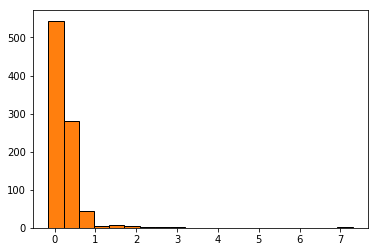

In [9]:
### Calmar Ratio

#https://www.newtraderu.com/2020/01/29/the-calmar-ratio-explained/

Average_Annual_RR = [np.mean(i) for i in Annualized_Returns]

np.mean(Average_Annual_RR)

plt.hist(Average_Annual_RR, bins = 20)

calmar_Ratio = [i/j for i, j in zip(Average_Annual_RR, max_Drawdowns_fund)]

calmar_Ratio[-10:]

calmar_clean = [i for i in calmar_Ratio if str(i)!= 'inf' and i< 10]

np.mean(calmar_clean)

outliers = [i for i in calmar_clean if i >= 10 ]


plt.hist(calmar_clean, bins = 20, edgecolor = 'black')

(array([ 15.,  80., 337., 304., 111.,  33.,   6.,   7.,   2.,   0.,   2.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.6258608 , -0.31647784, -0.00709487,  0.30228809,  0.61167105,
         0.92105402,  1.23043698,  1.53981994,  1.8492029 ,  2.15858587,
         2.46796883,  2.77735179,  3.08673475,  3.39611772,  3.70550068,
         4.01488364,  4.3242666 ,  4.63364957,  4.94303253,  5.25241549,
         5.56179846]),
 <a list of 20 Patch objects>)

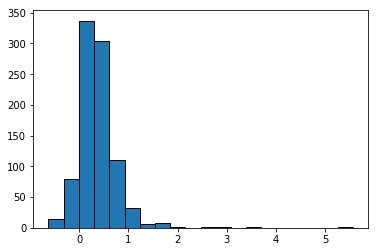

In [10]:


### Sharpe Ratio

#Average_Annual_RR 

std_funds = [np.std(i) for i in Annualized_Returns]

SharpeRatios = [i/j for i,j in zip(Average_Annual_RR,std_funds)]

plt.hist(SharpeRatios, bins = 20, edgecolor = 'black')